# Model Building

This file is part of my work on Udacity's Nano Degree Programme.

As capstone project I compare the performance of a machine learning model in predicting matches of the 2020 UEFA European Football Championship with emy personal bets in a football guessing game played on the platform www.kicktipp.de

In this notebook a simple model is trained that predicts the number of goals of a team in a match. As features serve the rolling averages that arise from the previous feature engineering step.

The model is a simple Random Forest trained using GridSearch. As parameters for GridSearch serve the depth of the tree and the different types of rolling averages from the feature engineering step.

Afterwards, the performance of the model is measured w.r.t. accuracy and the mean absolute error. Moreover, we compute a histogram of the differences between prediction and actual goals, and the confusion matrix.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

In [4]:
import pickle

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
from sklearn.pipeline import Pipeline

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix

## Input parameter

In [10]:
file_matches_training = '20220323_features_matches_training.xlsx'
name_output_model = 'model_v3.pkl'

path_input = '../data/'
path_models = '../models/'

## Model building

In [11]:
# The FeatureSelectionTransformer chooses only engineered features w.r.t. a single (weighted) average
class FeatureSelectionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, type_feat = 'weighted_mean_10'):
        self.type_feat = type_feat
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        '''
        INPUT: Dataframe X
        OUTPUT: X restricted to the columns specified in 'type_feat' and the columns are sorted
        '''
        cols_feat = X.columns
        cols_feat_selected = [col for col in cols_feat if self.type_feat in col]
        
        cols_feat_selected.sort()
        
        return X[cols_feat_selected]

### Preparation of Train, Test, Split

In [12]:
# Reading of the training data
df_train = pd.read_excel(os.path.join(path_input, file_matches_training))

In [13]:
df_train.head(5)

,date,team_A,team_B,goals_A,goals_weighted_mean_5_A,goals_weighted_mean_10_A,goals_normal_mean_5_A,goals_normal_mean_10_A,attempts_total_weighted_mean_5_A,attempts_total_weighted_mean_10_A,...,blocks_normal_mean_5_B,blocks_normal_mean_10_B,clearances_weighted_mean_5_B,clearances_weighted_mean_10_B,clearances_normal_mean_5_B,clearances_normal_mean_10_B,passes_accuracy_weighted_mean_5_B,passes_accuracy_weighted_mean_10_B,passes_accuracy_normal_mean_5_B,passes_accuracy_normal_mean_10_B
0,2020-09-04 18:45:00,Italy,Bosnia and Herzegovina,1,4.244941,4.116726,4.2,3.7,18.396572,19.617894,...,3.4,2.7,0.0,0.000000,0.0,0.0,78.923203,84.556986,87.6,86.6
1,2020-09-04 18:45:00,Netherlands,Poland,1,2.509940,2.637424,2.8,2.7,17.417330,17.555740,...,3.4,2.8,0.0,0.000000,0.0,0.0,75.829301,81.102871,84.8,83.2
2,2020-09-07 18:45:00,Bosnia and Herzegovina,Poland,1,1.505589,1.764878,1.8,1.9,14.557373,16.215489,...,3.0,2.9,0.0,0.000000,0.0,0.0,74.230419,80.144467,83.8,83.5
3,2020-09-07 18:45:00,Netherlands,Italy,0,1.942797,2.272537,2.2,2.4,16.164877,17.235452,...,2.8,2.2,0.0,0.000000,0.0,0.0,80.241055,86.418340,89.8,89.4
4,2020-10-11 16:00:00,Bosnia and Herzegovina,Netherlands,0,1.066147,1.536431,1.2,1.9,14.566120,15.793928,...,2.0,2.3,0.0,0.938661,0.0,2.2,77.367331,83.784879,87.0,87.2


In [14]:
cols_blacklist = ['date', 'team_A', 'team_B', 'goals_A', 'goals_B']
cols_to_keep = [col for col in df_train.columns if col not in cols_blacklist]

In [15]:
X = df_train[cols_to_keep]
y = df_train['goals_A'].astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Pipeline and GridSearch

In [17]:
# We train a very simple model.
# It justs consists of a feature selection (which type of rolling average we choose) and a RandomForest
pipe = Pipeline([('Transformer_FeatSelection', FeatureSelectionTransformer()),
                 ('clf', RandomForestClassifier(n_estimators = 200, n_jobs = 4))
                ])

In [18]:
# The GridSearch just performs on the different types of rolling averages and different depths of the random forest
parameters = {'Transformer_FeatSelection__type_feat' : ['weighted_mean_5', 'weighted_mean_10', 'normal_mean_5', 'normal_mean_10'],
              'clf__max_depth' : [3, 5, 10, 20]
             }

In [19]:
cv = GridSearchCV(pipe, param_grid = parameters, verbose = 3)

In [20]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\carst\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV 1/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=3;, score=0.350 total time=   1.2s
[CV 2/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=3;, score=0.362 total time=   0.1s
[CV 3/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=3;, score=0.394 total time=   0.1s
[CV 4/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=3;, score=0.384 total time=   0.1s
[CV 5/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=3;, score=0.365 total time=   0.0s
[CV 1/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=5;, score=0.338 total time=   0.1s
[CV 2/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=5;, score=0.325 total time=   0.1s
[CV 3/5] END Transformer_FeatSelection__type_feat=weighted_mean_5, clf__max_depth=5;, score=0.356 total time=   0.1s
[CV 4/5] END Transformer_FeatSelection__type_feat=weighted_mean_

[CV 2/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=10;, score=0.375 total time=   0.1s
[CV 3/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=10;, score=0.381 total time=   0.1s
[CV 4/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=10;, score=0.333 total time=   0.1s
[CV 5/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=10;, score=0.365 total time=   0.1s
[CV 1/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=20;, score=0.319 total time=   0.1s
[CV 2/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=20;, score=0.394 total time=   0.1s
[CV 3/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=20;, score=0.375 total time=   0.1s
[CV 4/5] END Transformer_FeatSelection__type_feat=normal_mean_10, clf__max_depth=20;, score=0.340 total time=   0.1s
[CV 5/5] END Transformer_FeatSelection__type_feat=normal_mean_10

GridSearchCV(estimator=Pipeline(steps=[('Transformer_FeatSelection',
                                        FeatureSelectionTransformer()),
                                       ('clf',
                                        RandomForestClassifier(n_estimators=200,
                                                               n_jobs=4))]),
             param_grid={'Transformer_FeatSelection__type_feat': ['weighted_mean_5',
                                                                  'weighted_mean_10',
                                                                  'normal_mean_5',
                                                                  'normal_mean_10'],
                         'clf__max_depth': [3, 5, 10, 20]},
             verbose=3)

## Measuring the Model Performance

In [21]:
predictions = cv.predict(X_test)
difference = y_test - predictions

### Accuracy, Confusion Matrix and Distribution of the Error

In [22]:
# Measuring the accuracy, i.e., the number of predictions, where we predict the correct number of goals
accuracy_score(y_test, predictions)

0.3533834586466165

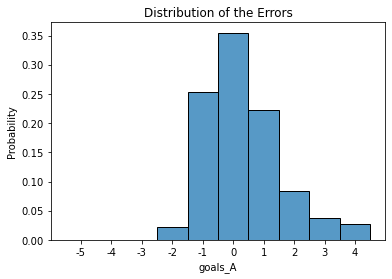

In [23]:
# Visualization of the distribution of the errors

ax = sns.histplot(data = difference, bins = list(range(-5, 6, 1)), stat = 'probability')

mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
ax.set_xticks(mids)
ax.set_xticklabels(list(range(-5, 5, 1)))
ax.set_title('Distribution of the Errors')
plt.show()

In [24]:
# Confusion matrix
confusion_matrix(y_test, predictions, labels = list(range(0, 9, 1)))

array([[23, 63,  6,  0,  0,  0,  0,  0,  0],
       [11, 65,  4,  0,  0,  0,  0,  0,  0],
       [ 4, 41,  6,  0,  0,  0,  0,  0,  0],
       [ 1, 14,  6,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  4,  1,  0,  0,  0,  0,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [25]:
# Average difference between number of goals scored and the predictions
mean_absolute_error(y_test, predictions)

0.924812030075188

## Export of Model

In [26]:
pickle.dump(cv, open(os.path.join(path_models, name_output_model), 'wb'))